In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Before running make sure you have a path pointing to the test and training data. Set the colab_base_path to your own path.

In [ ]:
from PIL.Image import Image
%matplotlib inline 
from matplotlib import pyplot as plt
import matplotlib.image as img
import numpy as np
import math

train_folder = './Train1/'
test_folder = './Test1/'

colab_base_path = "THIS SHOULD BE PATH TO YOUR TRAINING DATA"


In [ ]:
def compressor(path, k):
  img1 = img.imread(path)
  U,S,V = np.linalg.svd(img1,full_matrices=False)

  result_img = np.dot(U[:,:k],np.dot(np.diag(S[:k]),V[:k,:]))
  plt.figure()
  plt.title(f'{k} Value')
  plt.imshow(result_img, cmap='gray')
  return result_img

In [ ]:
#To gain some insight on how SVD can compress someones face, we tried to check 
#the effect of compression on an image for different values of k

file_path = colab_base_path + train_folder + 'train99.jpg'
# # k = 130
c = compressor(file_path, 130)
# # k = 100
c = compressor(file_path, 100)
# # k = 70
c = compressor(file_path, 70)
# # k = 50
c = compressor(file_path, 50)
# # k = 35
c = compressor(file_path, 35)
# # k = 20
c = compressor(file_path, 20)  

In [ ]:
# This is our main functions block where we can call function to perform the 
# repettive or specialized tasks we need 

# Image to vector
def img_to_vec(img_path):
  img_arr = img.imread(img_path)
  size =  np.shape(img_arr)[0] * np.shape(img_arr)[1]
  img_vec = np.reshape(img_arr, (size, 1))
  img_vec = img_vec.astype('int32')
  return img_vec

# converting n images into vectors
def n_img_vec_matrix(base_path, beg_img, end_img):

  for image in range(beg_img, end_img + 1):
    img_vec = img_to_vec(base_path + train_folder + f'train{image}.jpg')
    
    if image == beg_img:
      vecs = np.array(img_vec)
    else:
      vecs = np.column_stack((vecs, img_vec))
  return vecs

# return (mean, original images as vector matrix) (step 3)
def avg_face_vec(base_path, beg_img, end_img):
  img_matrix = n_img_vec_matrix(base_path, beg_img, end_img)
  #take columnWise mean
  num_rows = np.shape(img_matrix)[0]
  mean = img_matrix.mean(1)
  return (np.reshape(mean,(num_rows,1)),img_matrix)
  
#subtract the mean face (step 4)
def subtract_mean(mean, vecs):
  num_rows = np.shape(vecs)[0]

  #turn mean into row vector with num_rows number of columns
  sub = (vecs.transpose() - mean.T).transpose()
  return sub

# showing the image
def show_image(vec, dim1, dim2):
  a_reshape = np.reshape(vec, (dim1, dim2))
  plt.imshow(a_reshape, interpolation='nearest') #display the image 
  plt.gray()

# Choose the number of files we want to use

In [ ]:
#Preprocessing of all the files and calculation of the A matrix
num_files = 3770
#total images = 3771
#calculate the mean and vectors
face_mean, vecs = avg_face_vec(colab_base_path, 0,num_files)
original_vecs = vecs
#Calculate the Mean subtracted A matrix
#columns of A are pictures without the mean
A = subtract_mean(face_mean, original_vecs)


<Figure size 432x288 with 0 Axes>

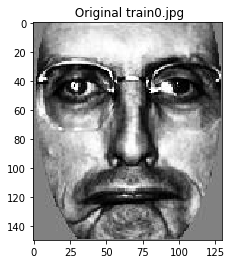

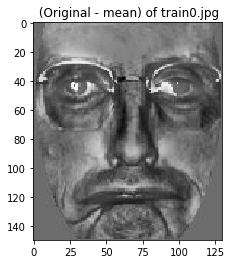

In [ ]:
#Showing an image from the A matrix which has the mean subtracted from it
plt.figure()
num = 0
plt.figure()
plt.title(" Original train" + str(num)+ ".jpg")
show_image(vecs[:,num], 150, 130)

plt.figure()
plt.title(" (Original - mean) of train" + str(num)+ ".jpg")
show_image(A[:,num], 150, 130)


#Try to find the best K value for the face basis

In [ ]:
#The A matrix has 19500 rows and is comprised of the full number of images/cols
U,S,V = np.linalg.svd(A,full_matrices=False) # getting eigenvectors
# cols of V are orthonormal eigenvectors of ATA
# cols of U are orthonormal eigenvectors of AAT

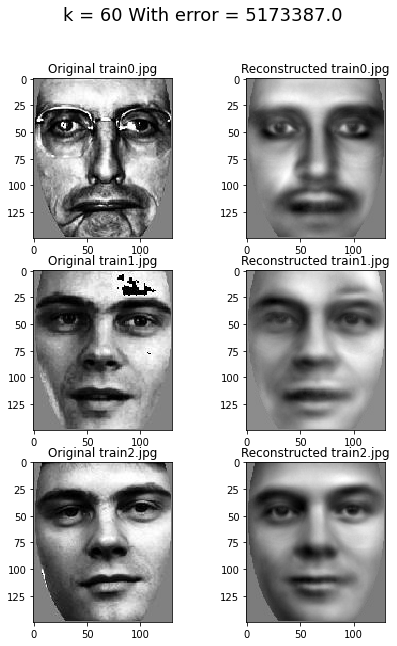


---------------------------------------------------------------



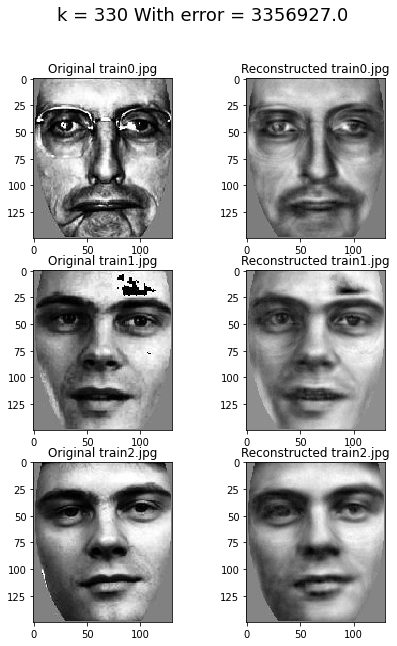


---------------------------------------------------------------



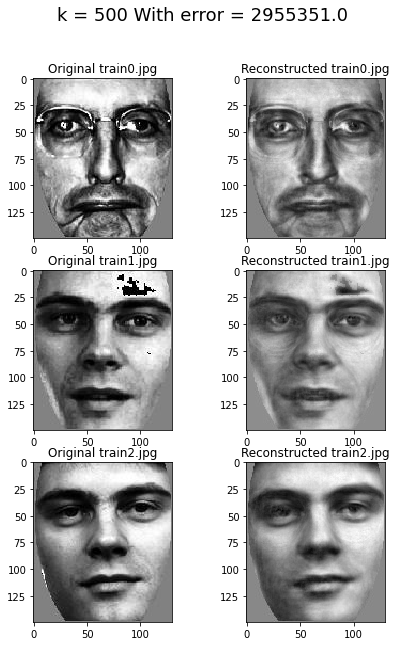


---------------------------------------------------------------



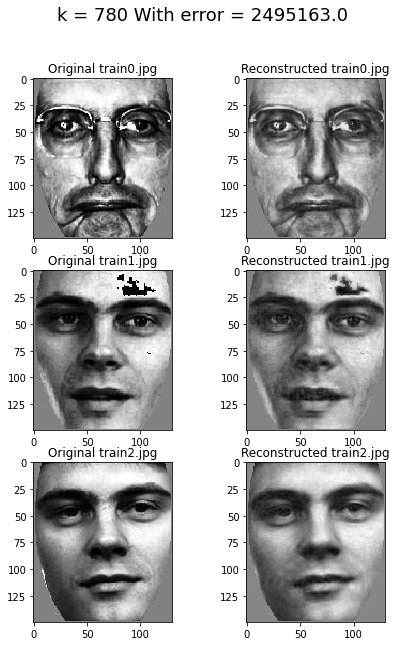


---------------------------------------------------------------



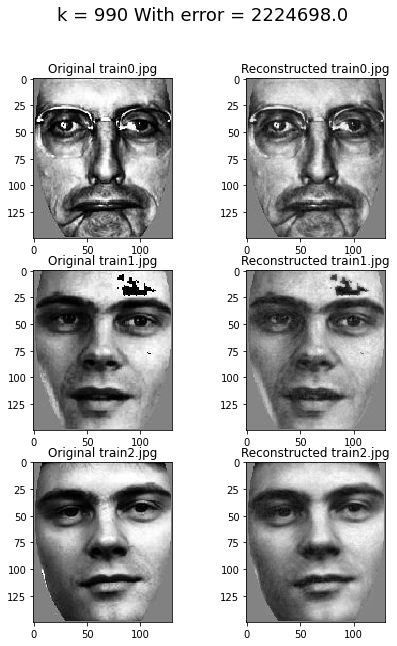


---------------------------------------------------------------



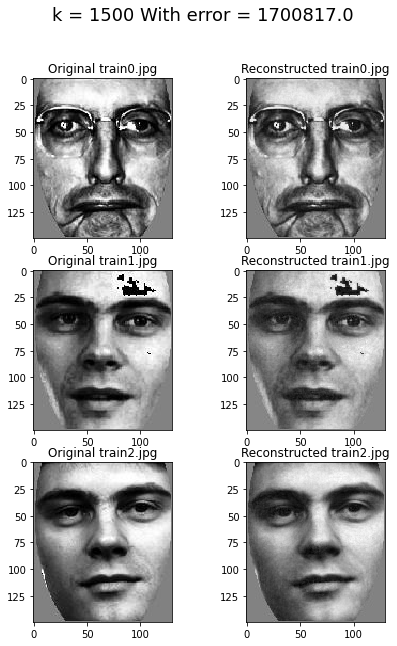


---------------------------------------------------------------



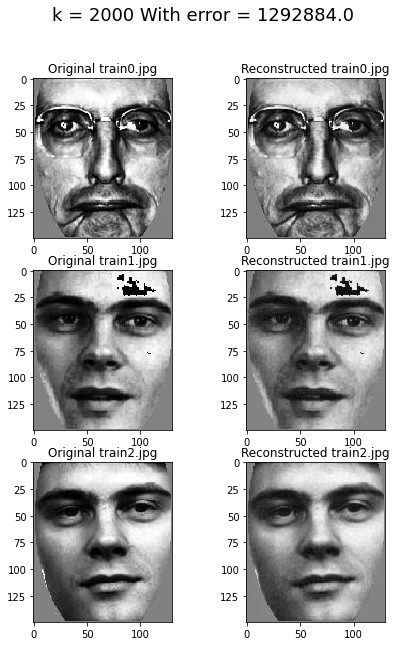


---------------------------------------------------------------



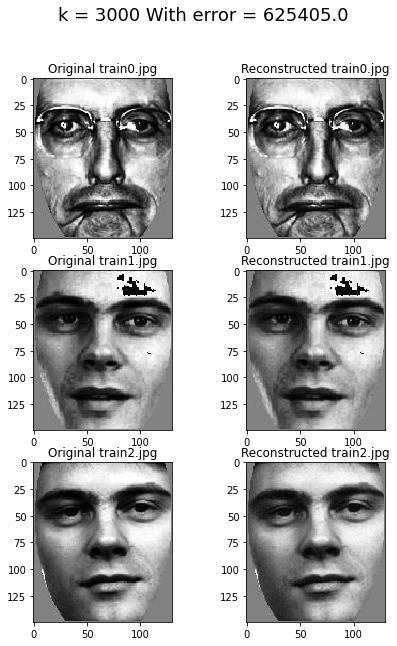


---------------------------------------------------------------



In [ ]:
#Experimentation on which k to pick

min_total = math.inf
best_k = 0

# The face_basis_k variable is the number of basis vectors to use 
# total number of files we input into our face basis
test_k_vals = [60,330,500,780,990,1500,2000,3000]

for face_basis_k in test_k_vals:

  #Calculate the u_eig vector with only the most important basis vecs
  u_eig = U[:,:face_basis_k]#
  
  # Calculation of the Overall Weight Matrx by dotting u_eig and A
  # W contains the weights of each image cooresponding with the colomn
  # Weights for image of col 0 from A matrix are in W[:,0]
  W = np.dot(u_eig.T, A) 

  # Calculating the reconstructed images with 
  # the dot product of eigen vectors with weight vectors 
  result = np.dot(u_eig, W)
  
  cols = face_basis_k
  
  #face_mean is a col vector and we want it as a row 
  #Add the mean back to the array
  #Adding back the Mean to each reconstructed face
  result = (result.T + face_mean.T).T
    # the result array contains all the reconstructed images 
    # using the weights, and means added back 
    # result has 19500 rows and 'number of files' number of images/cols
  
  #Calculating error value between actual and constructed
  #result = constructed images 
  #original_vecs = the original images
  #subtract and take the norm to find euclidian difference
  total = 0
  #print(f"k = {face_basis_k}")
  for i in range(num_files):
    total += np.linalg.norm(result[i] - original_vecs[i]) 

  if total < min_total:
    min_total = total 
    best_k = face_basis_k
 
  #Displaying a few of the linear combination of pics along with their originals
  num_of_face_pairs = 3
  dim1 = 150
  dim2 = 130
  count = 321
  fig = plt.figure()
  fig.suptitle(f"k = {face_basis_k} With error = {round(min_total,0)}", fontsize=18)

  fig.set_figheight(10)
  fig.set_figwidth(7)  
  for i in range(num_of_face_pairs):

    ax1 = fig.add_subplot(count)
    count +=1
    ax2 = fig.add_subplot(count)
    count +=1

    ax1.set_title(f"Original train{i}.jpg")
    reshaped_og_image = np.reshape(original_vecs[:,i], (dim1, dim2))
    ax1.imshow(reshaped_og_image, interpolation='nearest') #display the image 
    
    ax2.set_title(f"Reconstructed train{i}.jpg")     
    reshaped_result_image = np.reshape(result[:,i], (dim1, dim2))
    ax2.imshow(reshaped_result_image, interpolation='nearest') #display the image 
  
  plt.gray()
  plt.show()
  diff_k_path = colab_base_path + 'CV_projects_426/project1_folder/StarterFiles/Diff_Ks/'
  diff_k_path += f'k = {face_basis_k}'

  print()
  print("---------------------------------------------------------------\n")
# This confirms that with every added dimension, we decrease error between the 
# real image and the constructed image

#Displaying the Eigenfaces

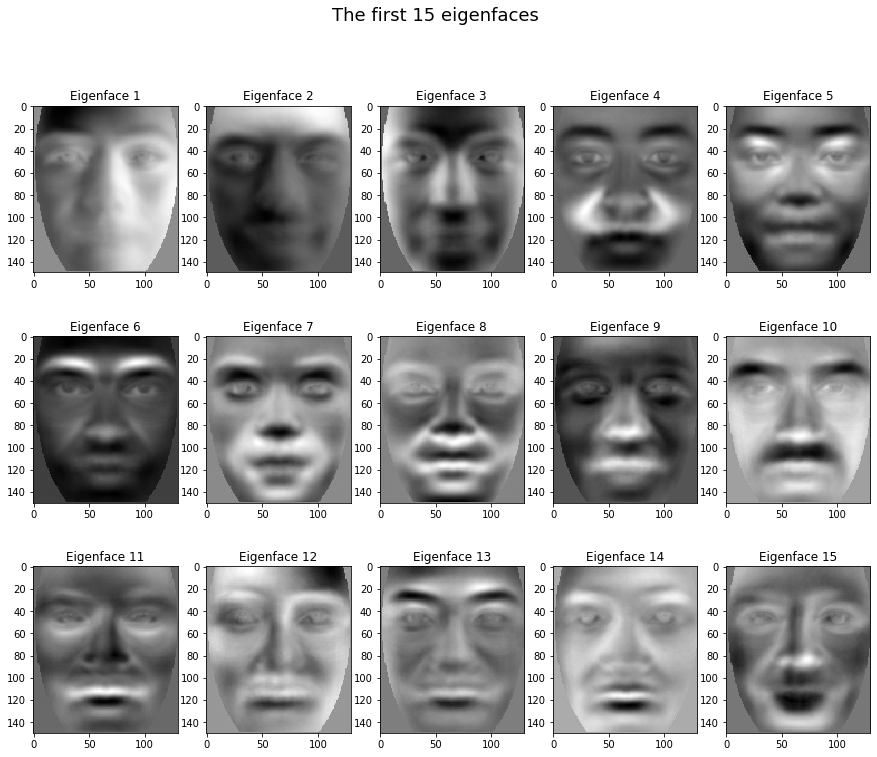

In [ ]:
# This code block turns all the svd reduced images in the A vector and extracts
# the weight vectors from them
#The A matrix has 19500 rows and is comprised of the full number of images/cols
#U,S,V = np.linalg.svd(A,full_matrices=False) # getting eigenvectors
# cols of V are orthonormal eigenvectors of ATA
# cols of U are orthonormal eigenvectors of AAT
# The face_basis_k variable is the number of basis vectors to use out to of the 
# total number of files we input into our face basis
face_basis_k = 990

#Calculate the u_eig vector with only the most important basis vecs
u_eig = U[:,:face_basis_k]
W = np.dot(u_eig.T, A) 
#u_eig = 19500x12 where 12 == k = num of cols

#Displaying a few of the eigenfaces in our face basis
num_of_eigen_faces = 15

##############################################################################
#Displaying a few of the linear combination of pics along with their originals
dim1 = 150
dim2 = 130
count = 1
fig = plt.figure()
fig.suptitle("The first " + str(num_of_eigen_faces) + " eigenfaces ", fontsize=18)

fig.set_figheight(12)
fig.set_figwidth(15) 

for i in range(num_of_eigen_faces):
  r = u_eig[:,i].reshape((150,130))
  ax1 = fig.add_subplot(3, 5, count)
  count +=1

  ax1.set_title(f"Eigenface {i + 1}")
  e_face = np.reshape(r, (dim1, dim2))
  ax1.imshow(e_face, interpolation='nearest') #display the image 
  

plt.gray()
plt.show()
eig_face_path = colab_base_path + 'CV_projects_426/project1_folder/StarterFiles/Eigenfaces/fifteen_eigen_faces'


#Face Recognition Section

In [ ]:
#Face Recognition
face_basis_k = 990

#Calculate the u_eig vector with only the most important basis vecs
u_eig = U[:,:face_basis_k]
W = np.dot(u_eig.T, A) 

result = np.dot(u_eig, W)
result = (result.T + face_mean.T).T

correct = 0
total = 0
num_files_to_test = 40
#folder = train_folder
folder = test_folder

#for testing

print("\n")

# #calculating the average error
# threshold = threshold/num_files
# print(f"threshold after div = {threshold}")

#by inspection, it seemed that an error below 189772  roughly = 1.9M meant that 
#the picture was guessed accurately 
threshold = 1890000

#dictionary has error val as key and image name as value 
dc = {}

for which_image in range(num_files_to_test):
  #Step 0: Initalize
  #which_image = 10

  #train9.jpg == index col 8
  unknown_image_path = colab_base_path + folder + 'test' + str(which_image)+ '.jpg'
  
  #imread the image
  unknown_img = img.imread(unknown_image_path)
  unknown_img_og_vec = unknown_img

  #Step 1: Normalize the image 
  vec_length =  np.shape(unknown_img)[0] * np.shape(unknown_img)[1]
  unknown_img_vec = np.reshape(unknown_img, (vec_length, 1))

  unknown_img_normalize = np.subtract(unknown_img_vec,face_mean)

  #Step 2: Project on the eigenspace
  w_unknown = np.dot(u_eig.T, unknown_img_normalize)

  unkown_projected_face = np.dot(u_eig, w_unknown) 

  unkown_projected_face = (unkown_projected_face.T + face_mean.T).T

  cols = face_basis_k
  min = math.inf
  b = False
  for  c in range(cols):
    w_c = np.reshape(W[:,c],(face_basis_k,1))
    diff = np.subtract(w_unknown,w_c)
    dist = np.linalg.norm(diff)
    if dist < min:
      min = dist
      pic = c
      b = True

  matched_str = ""
  #Determining error of each face
  ###############################################################
  diff_unknown_found = np.linalg.norm(unkown_projected_face - result[:,pic])
  
  file_name = f"test'{which_image}.jpg"
  dc[diff_unknown_found] = file_name

  if threshold > diff_unknown_found :
    matched_str = "Possible Correct Match"
    correct += 1

  total += 1
###############################################################
  #lets show all three on the same plot

  dim1 = 150
  dim2 = 130
  count = 321
  fig = plt.figure()
  fig.suptitle(f"Results for test{which_image}.jpg for k = {face_basis_k}: {matched_str}", fontsize=18)

  fig.set_figheight(5)
  fig.set_figwidth(12)  

  ax1 = fig.add_subplot(131)
  ax2 = fig.add_subplot(132)
  ax3 = fig.add_subplot(133)

  #actual
  s_act = "test" + str(which_image) + ".jpg"
  ax1.set_title(f"T{which_image} Actual Image: {s_act}")
  actual_image = np.reshape(unknown_img_og_vec, (dim1, dim2))
  ax1.imshow(actual_image, interpolation='nearest') #display the image 
  
  #projection
  s_un1 = "test" + str(which_image) + ".jpg"
  ax2.set_title(f"T{which_image} Projection of Unknown: {s_un1}")     
  projected_unknown = np.reshape(unkown_projected_face, (dim1, dim2))
  ax2.imshow(projected_unknown, interpolation='nearest') #display the image 
  
  #matched with
  s_un = "train" + str(pic) + ".jpg"
  ax3.set_title(f"T{which_image} Matched with : {s_un}")     
  matched_with = np.reshape(original_vecs[:,pic], (dim1, dim2))
  ax3.imshow(matched_with, interpolation='nearest') #display the image 

  plt.gray()
  plt.show()
  rec_path = colab_base_path + 'CV_projects_426/project1_folder/StarterFiles/Face_rec/'
  rec_path += f"result_test{which_image}.jpg"
  #fig.savefig(rec_path)
  print("\n")
  ################################################################################



b = dc.keys()
b = list(b)
b.sort()
print("Images with lowest error")
for i in range(5):
  print(dc[b[i]])

percent_correct = (correct/total)*100
print(f" Training error = {round(percent_correct,2)}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
b = list(b)
b.sort()
print("Images with lowest error")
for i in range(5):
  print(dc[b[i]])


Images with lowest error
test' + 27.jpg
test' + 16.jpg
test' + 0.jpg
test' + 21.jpg
test' + 11.jpg
